<a href="https://colab.research.google.com/github/Navya-S/ERA_Session10/blob/main/session10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Modules

In [1]:
import numpy as np
import torch
import torch.nn as nn

In [8]:
from models.custom_resnet import CustomResnet
from utils.data import train_dataset, test_dataset
from utils.training import train, test

from utils.common import (
    find_lr,
    one_cycle_lr,
    show_model_summary,
    show_img_grid,
    show_random_images,
    show_random_images_for_each_class,
    lossacc_plots,
    lr_plots,
)

100%|██████████| 170498071/170498071 [00:12<00:00, 13164373.92it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Create Dataloaders

In [11]:
batch_size = 512
shuffle = True
num_workers = 4

In [12]:
trainloader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

testloader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Check Sample Images

In [13]:
images, labels = next(iter(trainloader))

In [14]:
images[0].shape, labels[0]

(torch.Size([3, 32, 32]), tensor(3))

In [15]:
print(train_dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


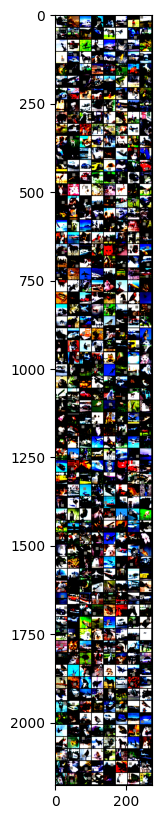

In [16]:
show_random_images(data_loader=trainloader)

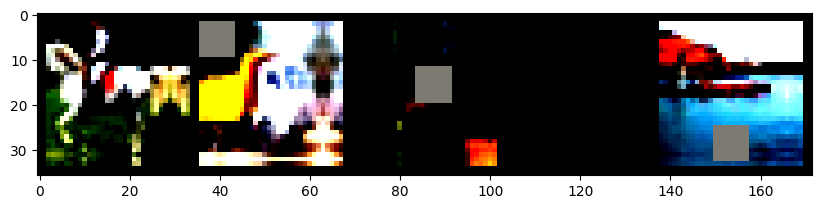

In [17]:
show_img_grid(images[25:30])

### Set Device

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [19]:
device

'cuda'

### Generate Model Summary

In [20]:
model = CustomResnet().to(device)

In [21]:
show_model_summary(model, batch_size)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Kernel Shape
CustomResnet                             [512, 3, 32, 32]          [512, 10]                 --                        --
├─Sequential: 1-1                        [512, 3, 32, 32]          [512, 64, 32, 32]         --                        --
│    └─Conv2d: 2-1                       [512, 3, 32, 32]          [512, 64, 32, 32]         1,728                     [3, 3]
│    └─BatchNorm2d: 2-2                  [512, 64, 32, 32]         [512, 64, 32, 32]         128                       --
│    └─ReLU: 2-3                         [512, 64, 32, 32]         [512, 64, 32, 32]         --                        --
├─Sequential: 1-2                        [512, 64, 32, 32]         [512, 128, 16, 16]        --                        --
│    └─Conv2d: 2-4                       [512, 64, 32, 32]         [512, 128, 32, 32]        73,728                    [3, 3]
│    └

### Declare Optimizer & Criterion

In [22]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.003, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

### Find LR

  0%|          | 0/600 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.19E-02


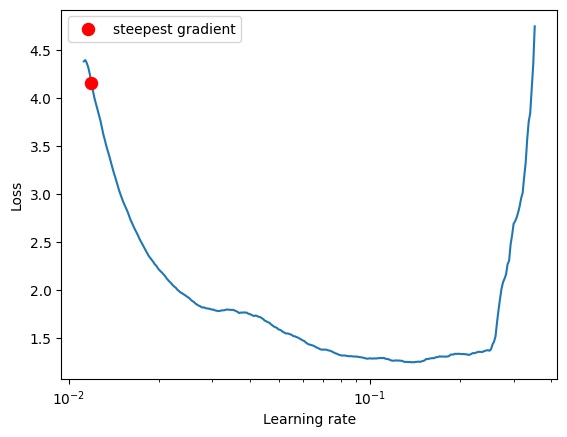

In [23]:
find_lr(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    trainloader=trainloader,
    numiter=600,
    endlr=10,
    startlr=1e-2,
)

### Create the Scheduler - One Cycle Policy

In [24]:
epochs = 24
maxlr = 1.19e-02
scheduler = one_cycle_lr(
    optimizer=optimizer, maxlr=maxlr, steps=len(trainloader), epochs=epochs
)

### Model Training & Evaluation

In [25]:
results = dict(trainloss=[], trainacc=[], testloss=[], testacc=[], epoch=[], lr=[])

for epoch in range(1, epochs + 1):
    print(f"Epoch: {epoch}")

    batch_trainloss, batch_trainacc, lrs = train(
        model=model,
        device=device,
        optimizer=optimizer,
        criterion=criterion,
        train_loader=trainloader,
        scheduler=scheduler,
    )

    results["trainloss"].append(np.mean(batch_trainloss))
    results["trainacc"].append(np.mean(batch_trainacc))

    testloss, testacc = test(
        model=model, device=device, criterion=criterion, test_loader=testloader
    )
    results["testloss"].append(testloss)
    results["testacc"].append(testacc)

    results["lr"].extend(lrs)
    results["epoch"].append(epoch)

Epoch: 1


Loss=1.00 Accuracy=51.56: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 1.1661, Accuracy: 5918/10000 (59.18%)

Epoch: 2


Loss=0.83 Accuracy=70.80: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.8485, Accuracy: 7067/10000 (70.67%)

Epoch: 3


Loss=0.72 Accuracy=76.14: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 1.0626, Accuracy: 6780/10000 (67.80%)

Epoch: 4


Loss=0.58 Accuracy=77.64: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.6424, Accuracy: 7873/10000 (78.73%)

Epoch: 5


Loss=0.63 Accuracy=80.12: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.8016, Accuracy: 7398/10000 (73.98%)

Epoch: 6


Loss=0.54 Accuracy=82.82: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.5143, Accuracy: 8251/10000 (82.51%)

Epoch: 7


Loss=0.59 Accuracy=84.50: 100%|██████████| 98/98 [00:21<00:00,  4.64it/s]



Test set: Average loss: 0.4436, Accuracy: 8482/10000 (84.82%)

Epoch: 8


Loss=0.39 Accuracy=86.09: 100%|██████████| 98/98 [00:20<00:00,  4.74it/s]



Test set: Average loss: 0.4731, Accuracy: 8442/10000 (84.42%)

Epoch: 9


Loss=0.38 Accuracy=87.24: 100%|██████████| 98/98 [00:20<00:00,  4.76it/s]



Test set: Average loss: 0.4593, Accuracy: 8412/10000 (84.12%)

Epoch: 10


Loss=0.42 Accuracy=87.70: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.4406, Accuracy: 8553/10000 (85.53%)

Epoch: 11


Loss=0.46 Accuracy=88.55: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.4516, Accuracy: 8582/10000 (85.82%)

Epoch: 12


Loss=0.40 Accuracy=88.98: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.4546, Accuracy: 8522/10000 (85.22%)

Epoch: 13


Loss=0.27 Accuracy=89.64: 100%|██████████| 98/98 [00:20<00:00,  4.69it/s]



Test set: Average loss: 0.3379, Accuracy: 8871/10000 (88.71%)

Epoch: 14


Loss=0.27 Accuracy=90.28: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.4148, Accuracy: 8649/10000 (86.49%)

Epoch: 15


Loss=0.18 Accuracy=90.75: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.5033, Accuracy: 8426/10000 (84.26%)

Epoch: 16


Loss=0.20 Accuracy=91.11: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.3718, Accuracy: 8790/10000 (87.90%)

Epoch: 17


Loss=0.25 Accuracy=91.95: 100%|██████████| 98/98 [00:20<00:00,  4.71it/s]



Test set: Average loss: 0.3167, Accuracy: 8948/10000 (89.48%)

Epoch: 18


Loss=0.18 Accuracy=92.97: 100%|██████████| 98/98 [00:20<00:00,  4.77it/s]



Test set: Average loss: 0.3360, Accuracy: 8900/10000 (89.00%)

Epoch: 19


Loss=0.16 Accuracy=93.30: 100%|██████████| 98/98 [00:20<00:00,  4.80it/s]



Test set: Average loss: 0.3054, Accuracy: 9002/10000 (90.02%)

Epoch: 20


Loss=0.23 Accuracy=94.12: 100%|██████████| 98/98 [00:20<00:00,  4.73it/s]



Test set: Average loss: 0.3080, Accuracy: 9033/10000 (90.33%)

Epoch: 21


Loss=0.15 Accuracy=95.24: 100%|██████████| 98/98 [00:20<00:00,  4.78it/s]



Test set: Average loss: 0.2547, Accuracy: 9149/10000 (91.49%)

Epoch: 22


Loss=0.11 Accuracy=96.28: 100%|██████████| 98/98 [00:20<00:00,  4.72it/s]



Test set: Average loss: 0.2376, Accuracy: 9244/10000 (92.44%)

Epoch: 23


Loss=0.07 Accuracy=97.20: 100%|██████████| 98/98 [00:20<00:00,  4.70it/s]



Test set: Average loss: 0.2346, Accuracy: 9289/10000 (92.89%)

Epoch: 24


Loss=0.06 Accuracy=97.90: 100%|██████████| 98/98 [00:20<00:00,  4.79it/s]



Test set: Average loss: 0.2196, Accuracy: 9338/10000 (93.38%)



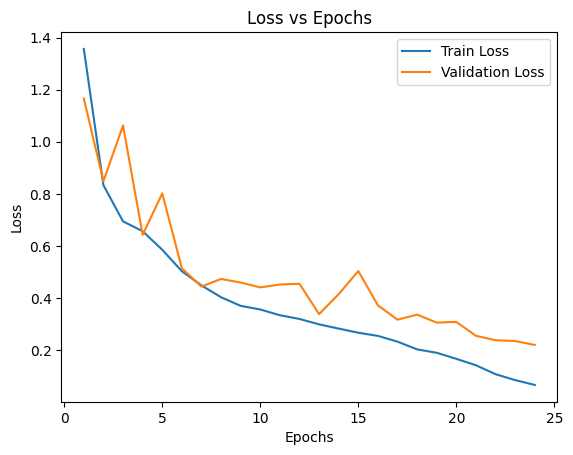

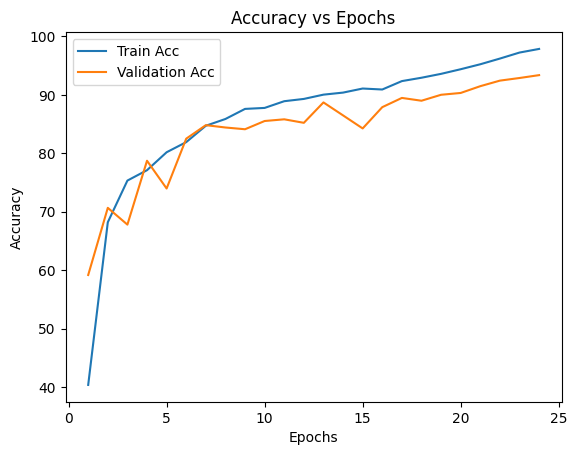

In [26]:
lossacc_plots(results)